# solve min (||Ax-b||**2) / n

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
torch.manual_seed(0)

In [2]:
def initialize_para(nn, val):
	for para in nn.parameters():
		para.data.fill_(val)
	return nn

In [3]:
class Model(nn.Module):
    '''Docstring fot the min{x}||A*x - b||**2 problem'''
    def __init__(self, n_samples, n_features):
        super(Model, self).__init__()
        self.n_samples = n_samples
        self.n_features = n_features
        self.A = Variable(torch.randn(n_samples, n_features), requires_grad = False)
        self.b = Variable(torch.randn(n_samples, 1), requires_grad = False)
        self.w = nn.Parameter(torch.zeros(n_features, 1), requires_grad=True)
    
    def forward(self):
        '''Compute the function A*x'''
        return torch.mm(self.A, self.w)
    
    def full_loss_grad(self, criterion):
        '''Compute the gradient norm and the full loss'''
        grad = 0
        output = self.forward()
        loss = criterion(output, self.b)
        loss.backward()
        for para in self.parameters():
            grad += para.grad.data.norm(2)**2
        return loss.data[0], (1./self.n_samples) * np.sqrt(grad)


    def partial_grad(self, criterion):
        '''Compute partial gradient of f'''
        i = np.random.randint(0, len(self.b))
        output = self.forward()
        loss = criterion(output[i], self.b[i])
        loss.backward()
        return i, loss
    
    def grad(self, criterion):
        '''compute the gradient'''
        output = self.forward()
        loss = criterion(output, self.b)
        loss.backward()
        return loss
    
    ##########GD Methodes

    def gd_backward(self, criterion, max_iter, lr):
        '''
        Compute the gd algorithm
        inputs : neural net, loss_function, number of epochs, learning rate
        goal : get a minimum
        return : total_loss_epoch, grad_norm_epoch
        '''
        total_loss_epoch = [0 for i in range(n_epoch)]
        grad_norm_epoch = [0 for i in range(n_epoch)]
        for epoch in range(n_epoch):
            #Compute full grad
            self.zero_grad() # grad = 0
            total_loss_epoch[epoch], grad_norm_epoch[epoch] = self.full_loss_grad(criterion)
            for i_data in range(self.n_samples):
                self.zero_grad()
                _ = self.grad(criterion)
                for para in self.parameters():
                    para.data -= lr * para.grad.data

        return total_loss_epoch, grad_norm_epoch


    ###########SGD Methodes

    
    def sgd_backward(self, criterion, max_iter, lr):
        '''
        Compute the sgd algorithm
        inputs : neural net, loss_function, number of epochs, learning rate
        goal : get a minimum
        return : total_loss_epoch, grad_norm_epoch
        '''
        total_loss_epoch = [0 for i in range(n_epoch)]
        grad_norm_epoch = [0 for i in range(n_epoch)]
        for epoch in range(n_epoch):
            #Compute full grad
            self.zero_grad() # grad = 0
            total_loss_epoch[epoch], grad_norm_epoch[epoch] = self.full_loss_grad(criterion)
            for i_data in range(self.n_samples):
                self.zero_grad()
                _, loss = self.partial_grad(criterion)
                for para in self.parameters():
                    para.data -= lr * para.grad.data

        return total_loss_epoch, grad_norm_epoch

    
########### SAGA Methodes

    def saga_backward(self, criterion, n_epoch, learning_rate):
        '''
        Compute the saga algorithm
        inputs : neural net, loss_function, number of epochs, learning rate
        goal : get a minimum
        return : total_loss_epoch, grad_norm_epoch
        '''
        grad_norm_epoch = [0 for i in range(n_epoch)]
        total_loss_epoch = [0 for i in range(n_epoch)]
        mean_grad = copy.deepcopy(self)#Simple net
        prev_stoc_grad = [copy.deepcopy(self) for i in range(self.n_samples)]#list of nets (one for each sample)
        epoch = 0
        for i in range(n_epoch * self.n_samples):
            if i % self.n_samples == 0:
                #Calculate loss & grad
                self.zero_grad()
                total_loss_epoch[epoch], grad_norm_epoch[epoch] = self.full_loss_grad(criterion)
                epoch += 1

            # Cur stoc grad
            self.zero_grad()
            i_data, loss = self.partial_grad(criterion)

            # backprop
            for para, para_prev, para_mean in zip(self.parameters(), prev_stoc_grad[i_data].parameters(), mean_grad.parameters()):
                saga_update = para.grad.data - para_prev.data + para_mean.data
                para_mean.data += (1./self.n_samples) * (para.grad.data - para_prev.data) #update mean
                para_prev.data = para.grad.data.clone() # update previous grad
                para.data.sub_(saga_update * learning_rate)

        return total_loss_epoch, grad_norm_epoch

    
########### SVRG Methodes

    def partial_grad_svrg(self, self_prev, criterion):
        '''Compute partial gradient of f for SVRG backward'''
        i = np.random.randint(0, len(self.b))
        self.zero_grad() #grad = 0
        self_prev.zero_grad() #grad = 0
        
        #cur_grad
        output = self.forward()
        loss = criterion(output[i], self.b[i])
        loss.backward()
        
        #prev_grad
        output2 = self_prev.forward()
        loss2 = criterion(output2[i], self.b[i])
        loss2.backward()
        
        return i, loss, loss2
    
    def svrg_backward(self, criterion, n_epoch, learning_rate):
        """
        Function to update weights with a SVRG backpropagation
        args : loss function, number of epochs, learning rate
        return : total_loss_epoch, grad_norm_epoch
        """
        total_loss_epoch = [0 for i in range(n_epoch)]
        grad_norm_epoch = [0 for i in range(n_epoch)]
        for epoch in range(n_epoch):
            running_loss = 0.0
            previous_net_sgd = copy.deepcopy(self) #update previous_net_sgd
            previous_net_grad = copy.deepcopy(self) #update previous_net_grad
            
            #Compute full grad
            previous_net_grad.zero_grad() # grad = 0
            total_loss_epoch[epoch], grad_norm_epoch[epoch] = previous_net_grad.full_loss_grad(criterion)

            #Run over the dataset
            for i_data in range(self.n_samples):
                #Compute cur stoc grad and prev stoc grad
                _, cur_loss, prev_loss = self.partial_grad_svrg(previous_net_sgd, criterion)
                
                #Backward
                for param1, param2, param3 in zip(self.parameters(), previous_net_sgd.parameters(), previous_net_grad.parameters()): 
                    param1.data -= (learning_rate) * (param1.grad.data - param2.grad.data + (1./self.n_samples) * param3.grad.data)
                
        return total_loss_epoch, grad_norm_epoch

In [12]:
loss_function = nn.MSELoss()
n_samples, n_features = 30, 5
net_svrg = Model(n_samples, n_features)
net_sgd = copy.deepcopy(net_svrg)
net_saga = copy.deepcopy(net_svrg)
net_gd = copy.deepcopy(net_svrg)

n_epoch = 3000
L = 1./(torch.mm(torch.t(net_sgd.A), net_sgd.A).data.norm(2))
lr_sgd = L
lr_svrg = 1 / (5 * torch.max(torch.mm(torch.t(net_svrg.A), net_svrg.A).sum(1)).data[0])

In [13]:
print('GD')
total_loss_epoch_gd, grad_norm_epoch_gd = net_gd.gd_backward(loss_function, n_epoch, lr_sgd)
print('SGD')
total_loss_epoch_sgd, grad_norm_epoch_sgd = net_sgd.sgd_backward(loss_function, n_epoch, lr_sgd)
print('SVRG')
total_loss_epoch_svrg, grad_norm_epoch_svrg = net_svrg.svrg_backward(loss_function, n_epoch, lr_svrg)
print('SAGA')
total_loss_epoch_saga, grad_norm_epoch_saga = net_saga.saga_backward(loss_function, n_epoch, lr_svrg)

GD
SGD
SVRG
SAGA


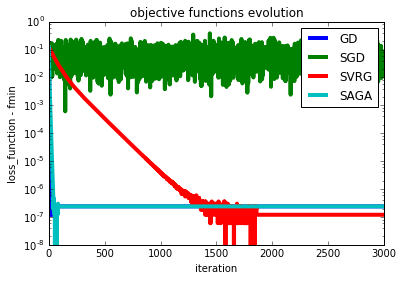

In [14]:
fmin = np.min(total_loss_epoch_saga)
plt.plot(range(n_epoch), total_loss_epoch_gd - fmin, lw=4, label = "GD")
plt.plot(range(n_epoch), total_loss_epoch_sgd - fmin, lw=4, label = "SGD")
plt.plot(range(n_epoch), total_loss_epoch_svrg - fmin, lw=4, label = "SVRG")
plt.plot(range(n_epoch), total_loss_epoch_saga - fmin, lw=4, label = "SAGA")

plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('loss_function - fmin')
plt.title('objective functions evolution')
plt.legend()
plt.show()

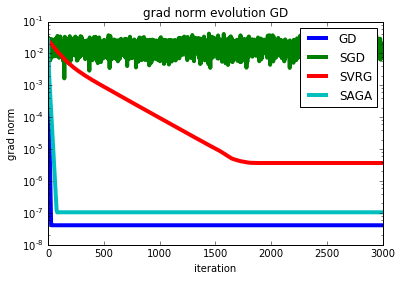

In [15]:
plt.plot(range(n_epoch), grad_norm_epoch_gd, lw=4, label = "GD")
plt.plot(range(n_epoch), grad_norm_epoch_sgd, lw=4, label = "SGD")
plt.plot(range(n_epoch), grad_norm_epoch_svrg, lw=4, label = "SVRG")
plt.plot(range(n_epoch), grad_norm_epoch_saga, lw=4, label = "SAGA")

plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('grad norm')
plt.title('grad norm evolution GD')
plt.legend()
plt.show()

In [16]:
print(np.min(total_loss_epoch_gd), np.min(total_loss_epoch_sgd), np.min(total_loss_epoch_svrg), np.min(total_loss_epoch_saga))

0.829831302166 0.830438673496 0.829831182957 0.829831182957
